In [ ]:
cd

C:\Users\workspace


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
# from tensorflow_docs.vis import embed
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

In [ ]:
IMG_SIZE = 224
MAX_SEQ_LENGTH = 20

In [ ]:
data_path = "./workspace1/data/"

In [ ]:
model_path = "./workspace1/models/"

In [ ]:
model_resnet152v2 = keras.models.load_model(model_path + 'resnet152v2_train.h5')

In [ ]:
train_df = pd.read_csv(data_path + "ucf101_top3/train.csv")

In [ ]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [ ]:
youtube_df = pd.DataFrame({
    'video_name' : ['youtube_criketshot_1.mp4', 'youtube_criketshot_2.mp4', 'youtube_punch_1.mp4', 'youtube_punch_2.mp4', 'youtube_tennisswing_1.mp4', 'youtube_tennisswing_2.mp4'],
    'tag' : ['CricketShot', 'CricketShot', 'Punch', 'Punch', 'TennisSwing', 'TennisSwing']
})

In [ ]:
youtube_df

,video_name,tag
0,youtube_criketshot_1.mp4,CricketShot
1,youtube_criketshot_2.mp4,CricketShot
2,youtube_punch_1.mp4,Punch
3,youtube_punch_2.mp4,Punch
4,youtube_tennisswing_1.mp4,TennisSwing
5,youtube_tennisswing_2.mp4,TennisSwing


In [ ]:
youtube_df['label'] = youtube_df['tag']
for index, data in enumerate(youtube_df["label"].unique()):
    youtube_df["label"].replace(data, index, inplace=True) 

In [ ]:
text_label = youtube_df['tag'].unique()

In [ ]:
youtube_df=sklearn.utils.shuffle(youtube_df)

In [ ]:
youtube_df

,video_name,tag,label
0,youtube_criketshot_1.mp4,CricketShot,0
1,youtube_criketshot_2.mp4,CricketShot,0
3,youtube_punch_2.mp4,Punch,1
5,youtube_tennisswing_2.mp4,TennisSwing,2
4,youtube_tennisswing_1.mp4,TennisSwing,2
2,youtube_punch_1.mp4,Punch,1


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
video = load_video(data_path+"youtube/"+youtube_df["video_name"].loc[0])

In [ ]:
video

array([[[[131, 152,  90],
         [131, 152,  90],
         [131, 152,  90],
         ...,
         [120, 148,  73],
         [121, 149,  74],
         [122, 152,  76]],

        [[131, 152,  90],
         [131, 152,  90],
         [131, 152,  90],
         ...,
         [121, 149,  74],
         [121, 149,  74],
         [120, 150,  74]],

        [[134, 155,  92],
         [134, 155,  91],
         [133, 154,  90],
         ...,
         [123, 151,  76],
         [123, 151,  76],
         [126, 151,  76]],

        ...,

        [[125, 149,  85],
         [125, 150,  85],
         [125, 149,  85],
         ...,
         [113, 145,  74],
         [113, 145,  73],
         [114, 146,  74]],

        [[126, 149,  85],
         [125, 148,  84],
         [125, 148,  83],
         ...,
         [114, 146,  75],
         [114, 146,  74],
         [114, 146,  74]],

        [[122, 145,  81],
         [119, 143,  79],
         [121, 144,  80],
         ...,
         [114, 146,  75],
        

In [ ]:
data_path+"youtube/"+youtube_df["video_name"].loc[0]

'./workspace1/data/youtube/youtube_criketshot_1.mp4'

In [ ]:
video.shape

(20, 224, 224, 3)

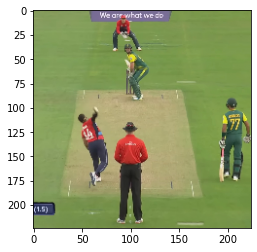

In [ ]:
plt.imshow(video[0]/255)

In [ ]:
def prepare_all_videos(video_name , label, root_dir):
    num_samples = len(video_name)
    video_paths = video_name.values.tolist()
    labels = label.values
    labels = labels.reshape(-1,1)
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    index = 0
    for idx, path in enumerate(video_paths):
        frames = load_video(root_dir+ path)
        for i in range(len(frames)):
            x[index] = np.array(frames[i], dtype="float32")
            y[index]= np.array(labels[idx], dtype="float32")
            index += 1 
    return (x,to_categorical(y))

In [ ]:
X_youtube, y_youtube = prepare_all_videos(youtube_df["video_name"], youtube_df["label"] , data_path + "youtube/")

In [ ]:
X_youtube.shape

(120, 224, 224, 3)

In [ ]:
model_resnet152v2.evaluate(
    X_youtube/255, y_youtube, batch_size = 20
)

6/6 [==============================] - 1s 132ms/step - loss: 0.0324 - acc: 1.0000


[0.03237355127930641, 1.0]

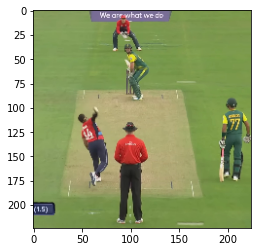

In [ ]:
plt.imshow(X_youtube[0]/255)

In [ ]:
frame = X_youtube[0:1]
predict_picture = model_resnet152v2.predict(frame/255)
predict_lable = np.argmax(predict_picture, axis = 1)
predict_text = text_label[predict_lable]
print('predict_text = ', predict_text)

predict_text =  ['CricketShot']


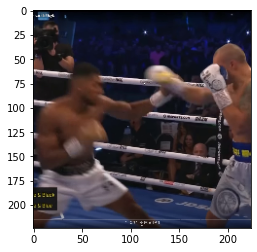

In [ ]:
plt.imshow(X_youtube[40]/255)

In [ ]:
frame = X_youtube[40:41]
predict_picture = model_resnet152v2.predict(frame/255)
predict_lable = np.argmax(predict_picture, axis = 1)
predict_text = text_label[predict_lable]
print('predict_text = ', predict_text)

predict_text =  ['Punch']
